==== showing original graph ====


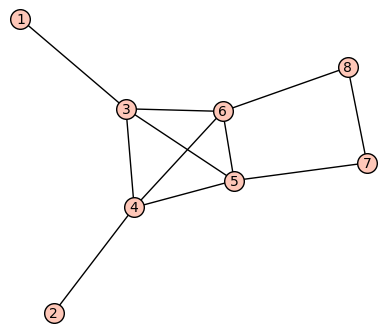

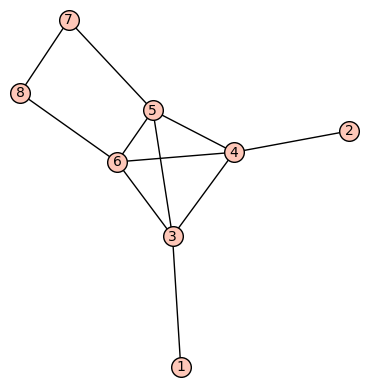

==== showing new cluster (yellow) + remaining nodes (white) ====


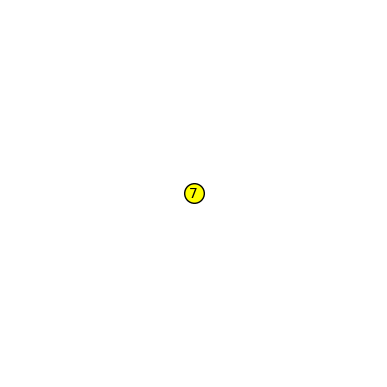

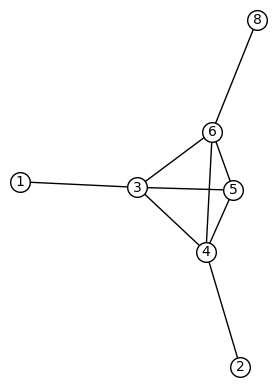

In [6]:
import numpy as np
import csv

verbose=1;

from sage.graphs.distances_all_pairs import *

fp = open("/tmp/graph.tex", 'w') 


def csv_graph(file):
    d = {}
    v = []
    i = 1

    with open(file, 'r') as f:
        table = csv.reader(f)

        for row in table:
            a = int(row[0])
            b = int(row[1])

            if a == i:
                v.append(b)
            else:
                d[i] = v
                i = a
                v = [b]

    return d
            

#d={0: [1,2,3], 1: [0,2], 2: [0,1], 3: [0,4], 4: [3,5], 5: [3,4]}
#d={1: [3], 2: [4], 3: [1,4,5,6], 4: [2,3,5,6], 5: [3,4,6,7], 6: [4,3,5,8], 7:[5,8], 8:[6,7]}

file = "./sample_2.csv"
d = csv_graph(file)

G=Graph(d);
print("==== showing original graph ====");
G.show();



pl=G.graphplot(vertex_colors='white')
print >> fp, 'original graph: \n \n'
print >> fp, '\\begin{figure}[h!]'
print >> fp, latex(G)
print >> fp, '\end{figure}'


print >> fp, '\clearpage \pagebreak';

       
H=G.copy();

H.add_vertex(6);
H.add_edge(6,3);
H.show();

current_cluster=Graph();
current_remainder=copy(G);

n=G.num_verts();
m=G.num_edges();

current_vertex=sage.misc.prandom.choice(G.vertices())
current_cluster.add_vertex(current_vertex);
current_remainder.delete_vertex(current_vertex);


if (false):
    
    current_cluster=copy(G);
    current_remainder=copy(G);
    
    current_cluster.delete_vertex(1);
    current_cluster.delete_vertex(2);
    current_cluster.delete_vertex(7);
    current_cluster.delete_vertex(8);
    
    current_remainder.delete_vertex(3);
    current_remainder.delete_vertex(4);
    current_remainder.delete_vertex(5);
    current_remainder.delete_vertex(6);
    
print("==== showing new cluster (yellow) + remaining nodes (white) ====");
current_cluster.show(vertex_colors='yellow');
current_remainder.show(vertex_colors='white');


if (current_cluster.num_verts() > 0):
    pl=current_cluster.graphplot(vertex_colors='white')
    print >> fp, 'first cluster: \n \n'
    print >> fp, '\\begin{figure}[h!]'
    print >> fp, latex(current_cluster)
    print >> fp, '\end{figure}'

pl=current_remainder.graphplot(vertex_colors='white')
print >> fp, 'remaining nodes: \n \n'
print >> fp, '\\begin{figure}[h!]'
print >> fp, latex(current_remainder)
print >> fp, '\end{figure}' 

print >> fp, '\clearpage \pagebreak';

moving: 18: (0.0500000000000000, 'move', -60.9500000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


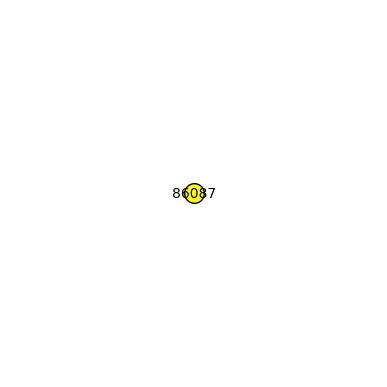

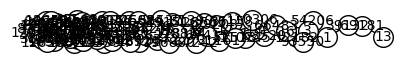

moving: 89757: (-0.900000000000000, 'move', -76.0000000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


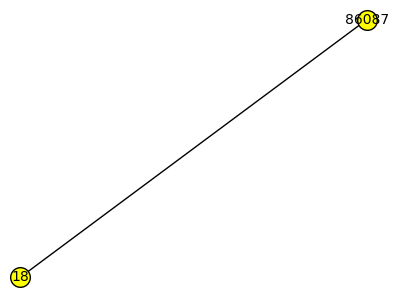

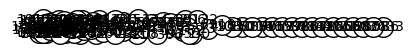

moving: 70687: (-1.85000000000000, 'move', -75.0500000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


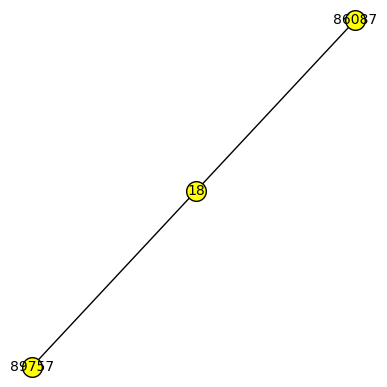

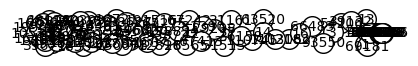

moving: 165926: (-2.80000000000000, 'move', -74.1000000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


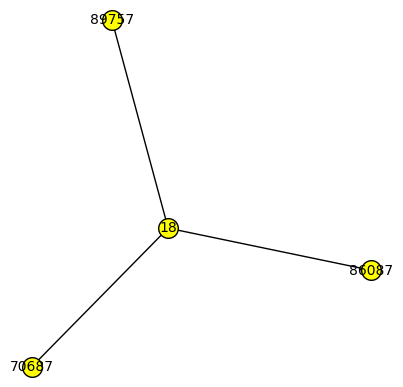

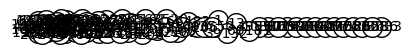

moving: 197807: (-3.75000000000000, 'move', -73.1500000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


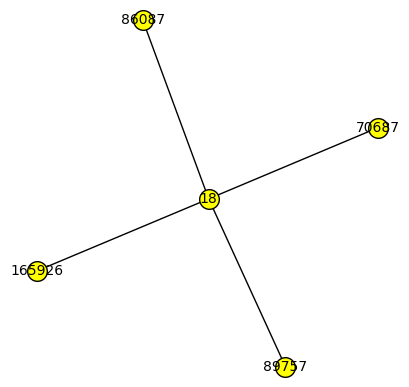

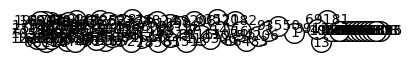

moving: 38833: (-4.70000000000000, 'move', -72.2000000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


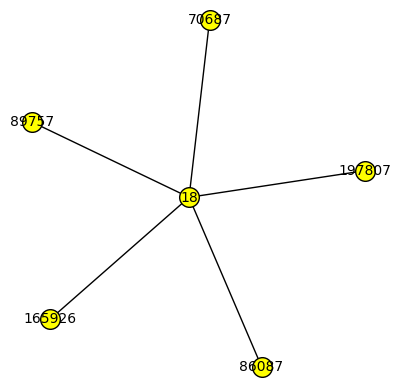

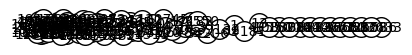

moving: 83386: (-5.65000000000000, 'move', -71.2500000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


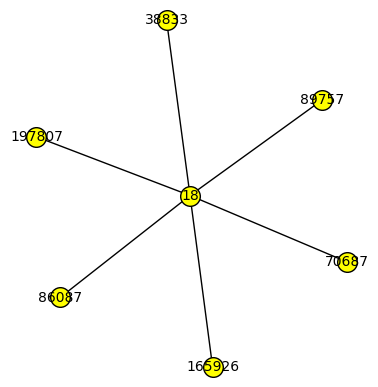

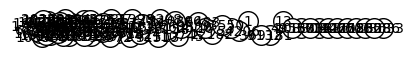

moving: 126582: (-6.60000000000000, 'move', -70.3000000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


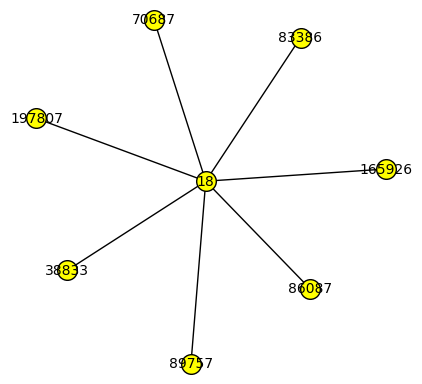

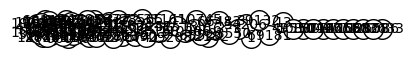

moving: 33633: (-7.55000000000000, 'move', -69.3500000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


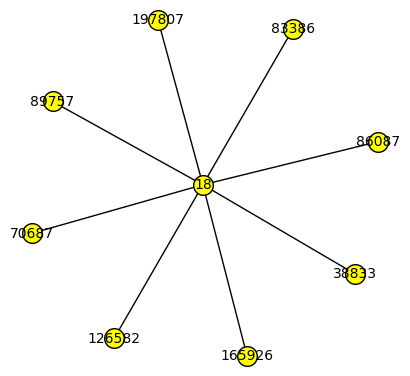

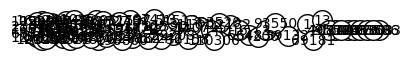

moving: 144771: (-8.50000000000000, 'move', -68.4000000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


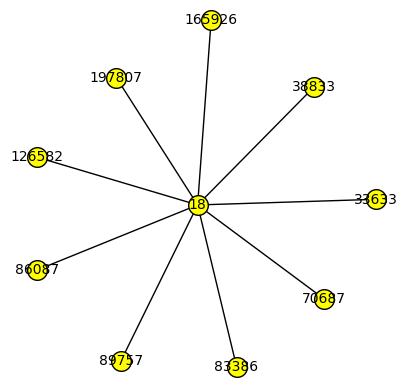

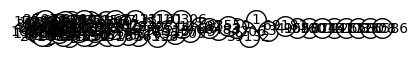

moving: 49550: (-9.45000000000000, 'move', -67.4500000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


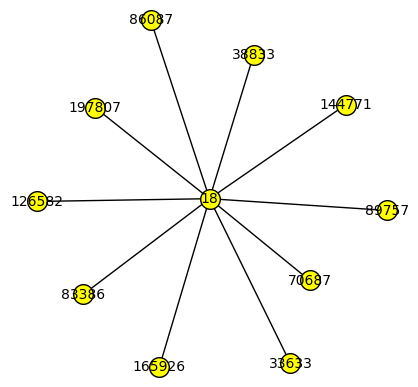

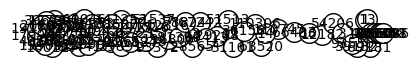

moving: 108303: (-10.4000000000000, 'move', -66.5000000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


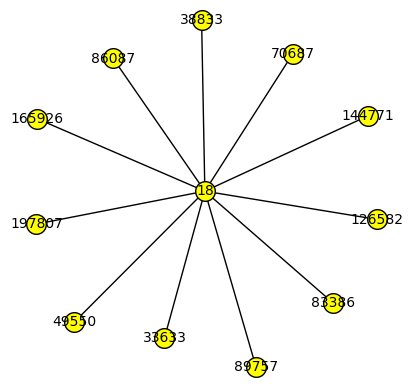

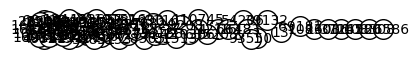

moving: 16016: (-11.3500000000000, 'move', -65.5500000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


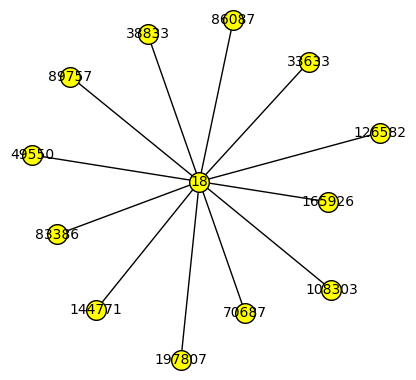

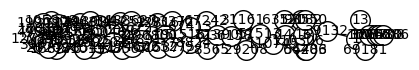

moving: 126580: (-12.3000000000000, 'move', -64.6000000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


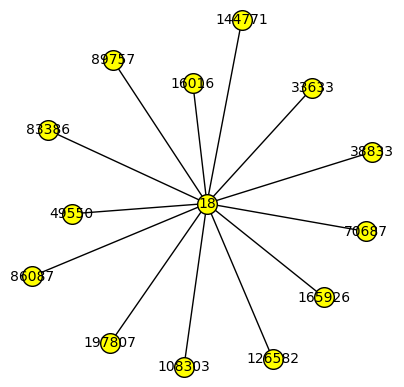

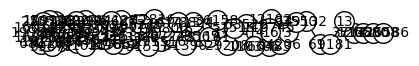

moving: 108308: (-13.2500000000000, 'move', -63.6500000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


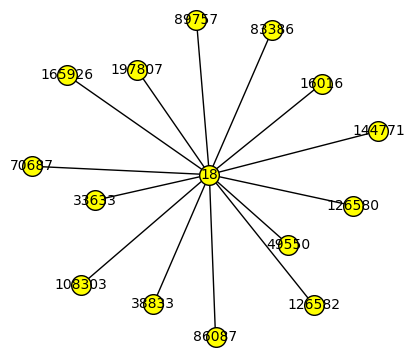

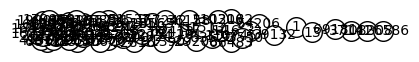

moving: 126586: (-14.2000000000000, 'move', -62.7000000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


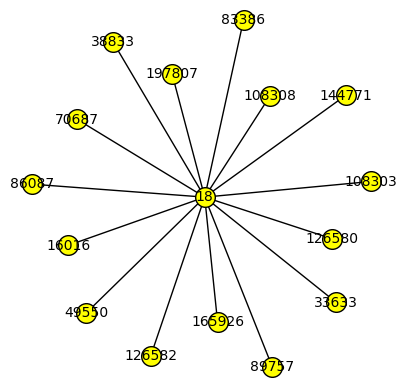

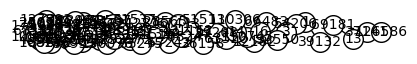

moving: 37141: (-15.1500000000000, 'move', -61.7500000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


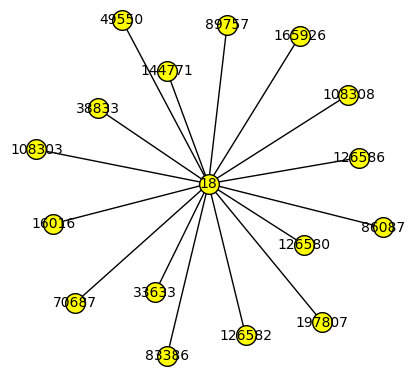

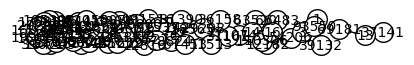

moving: 185347: (-17.1000000000000, 'move', -59.8000000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


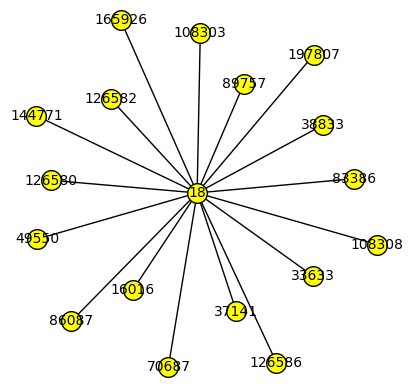

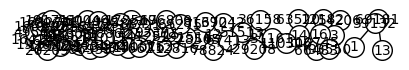

moving: 5: (-17.0500000000000, 'move', -51.8500000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


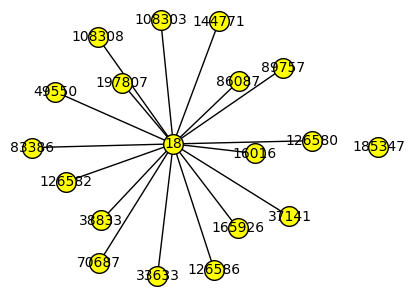

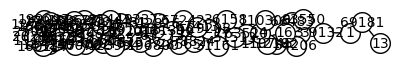

moving: 86953: (-18.0000000000000, 'move', -58.9000000000000, 'remain')
==== showing old cluster (yellow) + remaining nodes (white) ====


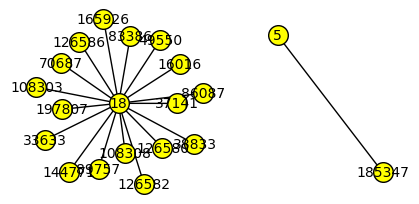

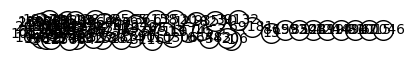

In [3]:
alpha=0.95;

moved=true;
nmoves=0;

while ((moved==true) and (nmoves < 20)):
    options={}
    bestresponse={}
    moved=false;
    for i in G.vertices():
        # print i
        if i in current_cluster.vertices():
            other='out'
            reference='cluster'
            other_graph=current_remainder
            reference_graph=current_cluster
        else:
            other='cluster'
            reference='out'
            other_graph=current_cluster
            reference_graph=current_remainder 
            
        di=reference_graph.degree(i);
        options[(i,reference)]=(di,(1-alpha)*di-alpha*(reference_graph.num_verts()-di-1));
        H=copy(other_graph);
        H.add_vertex(i);
        for j in other_graph.vertices():
            if i in G.neighbors(j): 
                H.add_edge(i,j);
                H.add_edge(j,i);
        di=H.degree(i);
        options[(i,other)]=(di,(1-alpha)*di-alpha*(H.num_verts()-di-1));
     
    
        if (options[(i,other)][1] > options[(i,reference)][1]):
            bestresponse[i]=(options[(i,other)][1],'move',options[(i,reference)][1],'remain');
        elif (options[(i,other)][1] < options[(i,reference)][1]):
            bestresponse[i]=(options[(i,reference)][1],'remain',options[(i,other)][1],'move');
        elif (sage.misc.prandom.choice([0,1])==0):
            bestresponse[i]=(options[(i,other)][1],'move','tie',options[(i,reference)][1],'remain');
        else:
            bestresponse[i]=(options[(i,reference)][1],'remain','tie',options[(i,other)][1],'move');
            
 
    print >> fp, '\n\n next best response vector.  node: (value, move/remain) \n\n';  
        
    for key, value in sorted(bestresponse.iteritems(), key=lambda (k,v): -v[0]):
        print >> fp, "%s: %s \n\n" % (key, value);   
            
    sys.stdout.flush();   
    
    for key, value in sorted(bestresponse.iteritems(), key=lambda (k,v): -v[0]):
        if (value[1]=='move'):
            print "moving: %s: %s" % (key, value);   
            break;
    
    if (value[1]=='move'):
        
        
        print("==== showing old cluster (yellow) + remaining nodes (white) ====");
        current_cluster.show(vertex_colors='yellow')
        current_remainder.show(vertex_colors='white')
        
        aux_string = str(key) + ' will move';
        print >> fp,  aux_string;
        if key in current_cluster.vertices():
            print('edges');
            print(G.edges());
            reference_graph=current_cluster;
            other_graph=current_remainder;
        else:
            reference_graph=current_remainder;
            other_graph=current_cluster;
        
        vertices_of_other_graph=copy(other_graph.vertices());
        other_graph.add_vertex(key);
        for j in vertices_of_other_graph:
            if key in G.neighbors(j): 
                other_graph.add_edge(key,j);
                other_graph.add_edge(j,key);
        reference_graph.delete_vertex(key);
            
        sys.stdout.flush();  
         

        print >> fp, '==== showing new cluster + remaining nodes ====';
        pl=current_cluster.graphplot(vertex_colors='yellow')
        
        print >> fp, 'current cluster: \n \n'
        print >> fp, '\\begin{figure}[h!]'
        print >> fp, latex(current_cluster)
        print >> fp, '\end{figure}'

        pl=current_remainder.graphplot(vertex_colors='white')
        print >> fp, 'current remainder: \n \n'
        print >> fp, '\\begin{figure}[h!]'
        print >> fp, latex(current_remainder)
        print >> fp, '\end{figure}'
       

        current_cluster.plot(vertex_colors='yellow').save('/tmp/foo.png');
        import matplotlib.pyplot
        img=matplotlib.image.imread('/tmp/foo.png')
        matrix_plot(img)
        
        current_remainder.plot(vertex_colors='white').save('/tmp/foo.png');

        sys.stdout.flush();
        
        print >> fp, '\clearpage \pagebreak';
         
        moved=true;
        nmoves=nmoves+1;
        

fp.close()